In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,classification_report
from sklearn.pipeline import Pipeline
from codecarbon import EmissionsTracker
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer

In [4]:
# Caminho para o arquivo no Google Drive
caminho_arquivo = '/content/drive/MyDrive/Inteligência artificial/Mestrado/Aprendizado de Máquina/Trabalho/Experimentos/weatherAUS.csv'

# Ler o arquivo usando pandas
df = pd.read_csv(caminho_arquivo)

# Exibir as primeiras linhas do dataframe
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.shape

(145460, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

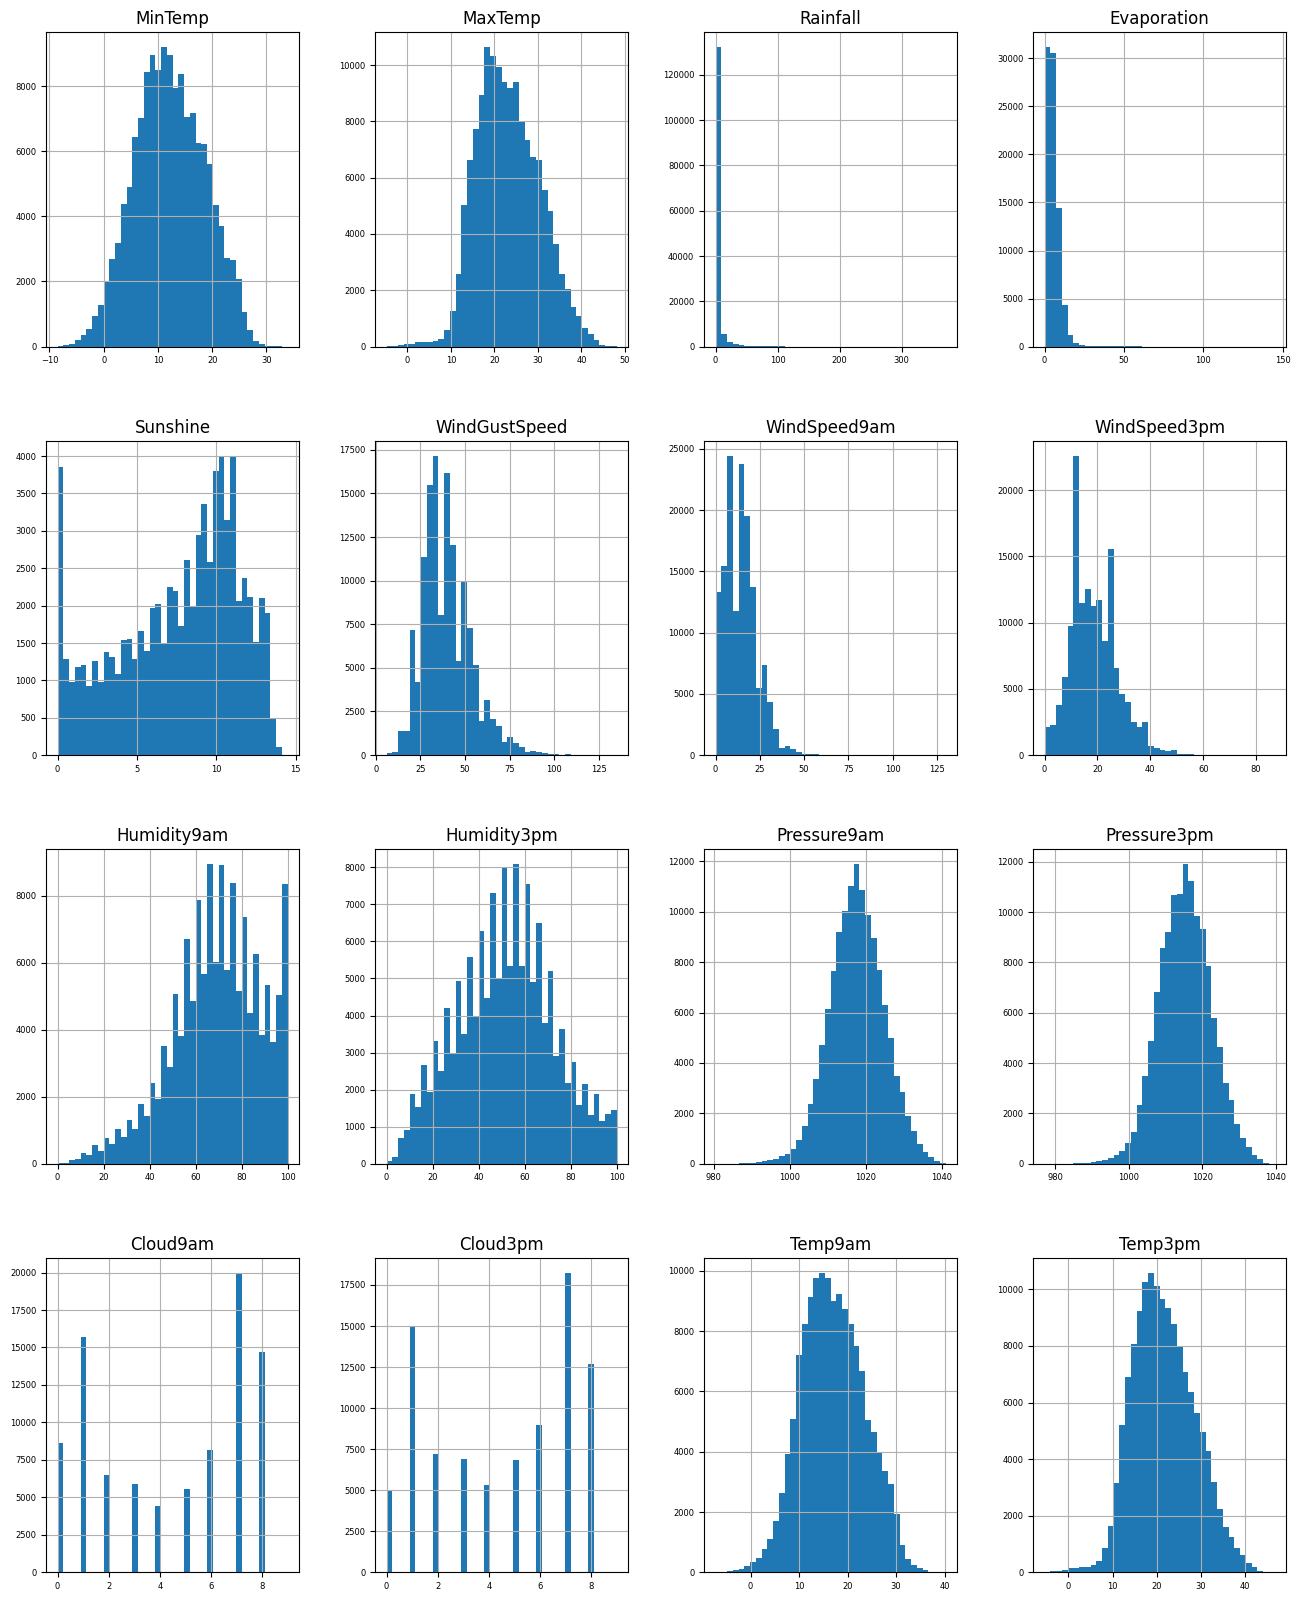

In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6);

###Verificar quantidade de classes nas variáveis categóricas

In [ ]:
df_cat = df.select_dtypes(include = ['object'])
df_cat.nunique().sort_values()

RainToday         2
WindGustDir      16
WindDir9am       16
WindDir3pm       16
Location         49
Date           3436
dtype: int64

In [ ]:
df.RainTomorrow.value_counts()

RainTomorrow
0.0    110316
1.0     31877
Name: count, dtype: int64

In [5]:
df = df.drop(columns = 'Date')

df_cat = df.select_dtypes(include = ['object'])
for column_name in df_cat.columns:
    df.dropna(subset=[column_name], inplace=True)

numerical_cols = df.select_dtypes(include = ['float64', 'int64']).columns

# Cria o SimpleImputer com a estratégia desejada (por exemplo, preencher com a média)
imputer = SimpleImputer(strategy='mean')

# Aplica o imputer às colunas numéricas
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

replacement_dict = {'Yes': 1, 'No': 0}
df['RainTomorrow'] = df['RainTomorrow'].replace(replacement_dict)

X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

categorical_cols = X.select_dtypes(include=['object']).columns

# Criar um ColumnTransformer para aplicar OneHotEncoder apenas nas colunas categóricas
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), categorical_cols)],
    remainder='passthrough'
)

# Ajustar e transformar o DataFrame
X_encoded = ct.fit_transform(X)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (98968, 113)
y_train shape: (98968,)
X_test shape: (24742, 113)
y_test shape: (24742,)


In [ ]:
'''from sklearn.model_selection import cross_val_score

score_lr=cross_val_score(rf_classifier, X_train, y_train,cv=3)
print(score_lr)
print("Avg :",np.average(score_lr))'''

[0.85941194 0.85774046 0.85686138]
Avg : 0.8580045933296653


In [13]:
###XGB

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
import xgboost as xgb


tracker = EmissionsTracker()
tracker.start()

# Configuração do K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

model = xgb.XGBClassifier()

# Configurando os scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),  # 'macro' para múltiplas classes
    'recall': make_scorer(recall_score, average='macro')
}

# Avaliando o modelo com cross_validate
scores = cross_validate(model, X_encoded, y, cv=kf, scoring=scoring, return_train_score=False)

# Exibindo as métricas
print(f"Acurácia por fold: {scores['test_accuracy']}")
print(f"Acurácia Média: {np.mean(scores['test_accuracy']):.4f}")
print(f"Desvio Padrão da Acurácia: {np.std(scores['test_accuracy']):.4f}")

print(f"Precisão por fold: {scores['test_precision']}")
print(f"Precisão Média: {np.mean(scores['test_precision']):.4f}")
print(f"Desvio Padrão da Precisão: {np.std(scores['test_precision']):.4f}")

print(f"Recall por fold: {scores['test_recall']}")
print(f"Recall Médio: {np.mean(scores['test_recall']):.4f}")
print(f"Desvio Padrão do Recall: {np.std(scores['test_recall']):.4f}")

tracker.stop()
tracker.final_emissions_data

[codecarbon WARNING @ 21:21:11] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:21:11] [setup] RAM Tracking...
[codecarbon INFO @ 21:21:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:21:11] No GPU found.
[codecarbon INFO @ 21:21:11] [setup] CPU Tracking...
[codecarbon WARNING @ 21:21:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:21:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:21:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:21:12] >>> Tracker's metadata:
[codecarbon INFO @ 21:21:12]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:21:12]   Python version: 3.10.12
[codecarbon INFO @ 21:21:12]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 21:21:12]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:21:12]   CPU count: 2
[codecarbon INFO @ 21:21:12]   CP

Acurácia por fold: [0.86553229 0.86496645 0.8627031  0.86334977 0.86286476]
Acurácia Média: 0.8639
Desvio Padrão da Acurácia: 0.0011
Precisão por fold: [0.82190855 0.8207516  0.8141157  0.81863654 0.82293911]
Precisão Média: 0.8197
Desvio Padrão da Precisão: 0.0031
Recall por fold: [0.76181797 0.76066609 0.75854438 0.75878075 0.75991863]
Recall Médio: 0.7599
Desvio Padrão do Recall: 0.0012


EmissionsData(timestamp='2024-06-10T21:21:38', project_name='codecarbon', run_id='f11982cc-a66a-4f2d-a6a8-0e2c7dd3a7d3', duration=24.79249858856201, emissions=9.287936194675585e-05, emissions_rate=3.746268719749192e-06, cpu_power=42.5, gpu_power=0.0, ram_power=4.753040313720703, cpu_energy=0.0002926117767890295, gpu_energy=0, ram_energy=3.270572171866055e-05, energy_consumed=0.00032531749850769003, country_name='United States', country_iso_code='USA', region='south carolina', cloud_provider='', cloud_region='', os='Linux-6.1.85+-x86_64-with-glibc2.35', python_version='3.10.12', codecarbon_version='2.4.2', cpu_count=2, cpu_model='Intel(R) Xeon(R) CPU @ 2.20GHz', gpu_count=None, gpu_model=None, longitude=-79.9746, latitude=32.8608, ram_total_size=12.674774169921875, tracking_mode='machine', on_cloud='N', pue=1.0)

In [14]:
### Regeressão Logística

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression


tracker = EmissionsTracker()
tracker.start()
# Configuração do K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

model = LogisticRegression()

# Configurando os scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),  # 'macro' para múltiplas classes
    'recall': make_scorer(recall_score, average='macro')
}

# Avaliando o modelo com cross_validate
scores = cross_validate(model, X_encoded, y, cv=kf, scoring=scoring, return_train_score=False)

# Exibindo as métricas
print(f"Acurácia por fold: {scores['test_accuracy']}")
print(f"Acurácia Média: {np.mean(scores['test_accuracy']):.4f}")
print(f"Desvio Padrão da Acurácia: {np.std(scores['test_accuracy']):.4f}")

print(f"Precisão por fold: {scores['test_precision']}")
print(f"Precisão Média: {np.mean(scores['test_precision']):.4f}")
print(f"Desvio Padrão da Precisão: {np.std(scores['test_precision']):.4f}")

print(f"Recall por fold: {scores['test_recall']}")
print(f"Recall Médio: {np.mean(scores['test_recall']):.4f}")
print(f"Desvio Padrão do Recall: {np.std(scores['test_recall']):.4f}")

tracker.stop()
tracker.final_emissions_data

[codecarbon WARNING @ 21:21:38] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:21:38] [setup] RAM Tracking...
[codecarbon INFO @ 21:21:38] [setup] GPU Tracking...
[codecarbon INFO @ 21:21:38] No GPU found.
[codecarbon INFO @ 21:21:38] [setup] CPU Tracking...
[codecarbon WARNING @ 21:21:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:21:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:21:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:21:39] >>> Tracker's metadata:
[codecarbon INFO @ 21:21:39]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:21:39]   Python version: 3.10.12
[codecarbon INFO @ 21:21:39]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 21:21:39]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:21:39]   CPU count: 2
[codecarbon INFO @ 21:21:39]   CP

Acurácia por fold: [0.84455582 0.84544499 0.84560666 0.84289871 0.84245413]
Acurácia Média: 0.8442
Desvio Padrão da Acurácia: 0.0013
Precisão por fold: [0.79100609 0.79409751 0.7901116  0.7902891  0.79526035]
Precisão Média: 0.7922
Desvio Padrão da Precisão: 0.0021
Recall por fold: [0.71841095 0.71682294 0.72034328 0.7133305  0.7160063 ]
Recall Médio: 0.7170
Desvio Padrão do Recall: 0.0024


EmissionsData(timestamp='2024-06-10T21:21:49', project_name='codecarbon', run_id='43cce38d-828f-4222-8b46-7ca29d4bbf78', duration=9.62613296508789, emissions=3.605570138270182e-05, emissions_rate=3.74560599915551e-06, cpu_power=42.5, gpu_power=0.0, ram_power=4.753040313720703, cpu_energy=0.00011359136369493274, gpu_energy=0, ram_energy=1.2696654815410967e-05, energy_consumed=0.0001262880185103437, country_name='United States', country_iso_code='USA', region='south carolina', cloud_provider='', cloud_region='', os='Linux-6.1.85+-x86_64-with-glibc2.35', python_version='3.10.12', codecarbon_version='2.4.2', cpu_count=2, cpu_model='Intel(R) Xeon(R) CPU @ 2.20GHz', gpu_count=None, gpu_model=None, longitude=-79.9746, latitude=32.8608, ram_total_size=12.674774169921875, tracking_mode='machine', on_cloud='N', pue=1.0)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

tracker = EmissionsTracker()
tracker.start()

# Configuração do K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

model = DecisionTreeClassifier()

# Configurando os scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),  # 'macro' para múltiplas classes
    'recall': make_scorer(recall_score, average='macro')
}

# Avaliando o modelo com cross_validate
scores = cross_validate(model, X_encoded, y, cv=kf, scoring=scoring, return_train_score=False)

# Exibindo as métricas
print(f"Acurácia por fold: {scores['test_accuracy']}")
print(f"Acurácia Média: {np.mean(scores['test_accuracy']):.4f}")
print(f"Desvio Padrão da Acurácia: {np.std(scores['test_accuracy']):.4f}")

print(f"Precisão por fold: {scores['test_precision']}")
print(f"Precisão Média: {np.mean(scores['test_precision']):.4f}")
print(f"Desvio Padrão da Precisão: {np.std(scores['test_precision']):.4f}")

print(f"Recall por fold: {scores['test_recall']}")
print(f"Recall Médio: {np.mean(scores['test_recall']):.4f}")
print(f"Desvio Padrão do Recall: {np.std(scores['test_recall']):.4f}")


tracker.stop()
tracker.final_emissions_data

[codecarbon WARNING @ 21:35:41] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:35:41] [setup] RAM Tracking...
[codecarbon INFO @ 21:35:41] [setup] GPU Tracking...
[codecarbon INFO @ 21:35:41] No GPU found.
[codecarbon INFO @ 21:35:41] [setup] CPU Tracking...
[codecarbon WARNING @ 21:35:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:35:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:35:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:35:42] >>> Tracker's metadata:
[codecarbon INFO @ 21:35:42]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:35:42]   Python version: 3.10.12
[codecarbon INFO @ 21:35:42]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 21:35:42]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:35:42]   CPU count: 2
[codecarbon INFO @ 21:35:42]   CP

Acurácia por fold: [0.79548945 0.7967828  0.79298359 0.79298359 0.79197316]
Acurácia Média: 0.7940
Desvio Padrão da Acurácia: 0.0018
Precisão por fold: [0.70376069 0.70504237 0.6993007  0.70056721 0.70318389]
Precisão Média: 0.7024
Desvio Padrão da Precisão: 0.0021
Recall por fold: [0.70841157 0.70851768 0.70667325 0.70451252 0.70443811]
Recall Médio: 0.7065
Desvio Padrão do Recall: 0.0018


EmissionsData(timestamp='2024-06-10T21:37:47', project_name='codecarbon', run_id='f90f28fb-e2c0-43a8-a70e-0d559de4073f', duration=123.67880606651306, emissions=0.00046323139923570253, emissions_rate=3.7454388020739944e-06, cpu_power=42.5, gpu_power=0.0, ram_power=4.753040313720703, cpu_energy=0.001459357102877564, gpu_energy=0, ram_energy=0.00016314844486688267, energy_consumed=0.0016225055477444466, country_name='United States', country_iso_code='USA', region='south carolina', cloud_provider='', cloud_region='', os='Linux-6.1.85+-x86_64-with-glibc2.35', python_version='3.10.12', codecarbon_version='2.4.2', cpu_count=2, cpu_model='Intel(R) Xeon(R) CPU @ 2.20GHz', gpu_count=None, gpu_model=None, longitude=-79.9746, latitude=32.8608, ram_total_size=12.674774169921875, tracking_mode='machine', on_cloud='N', pue=1.0)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

tracker = EmissionsTracker()
tracker.start()

# Configuração do K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

model = RandomForestClassifier()

# Configurando os scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),  # 'macro' para múltiplas classes
    'recall': make_scorer(recall_score, average='macro')
}

# Avaliando o modelo com cross_validate
scores = cross_validate(model, X_encoded, y, cv=kf, scoring=scoring, return_train_score=False)

# Exibindo as métricas
print(f"Acurácia por fold: {scores['test_accuracy']}")
print(f"Acurácia Média: {np.mean(scores['test_accuracy']):.4f}")
print(f"Desvio Padrão da Acurácia: {np.std(scores['test_accuracy']):.4f}")

print(f"Precisão por fold: {scores['test_precision']}")
print(f"Precisão Média: {np.mean(scores['test_precision']):.4f}")
print(f"Desvio Padrão da Precisão: {np.std(scores['test_precision']):.4f}")

print(f"Recall por fold: {scores['test_recall']}")
print(f"Recall Médio: {np.mean(scores['test_recall']):.4f}")
print(f"Desvio Padrão do Recall: {np.std(scores['test_recall']):.4f}")


tracker.stop()
tracker.final_emissions_data

[codecarbon WARNING @ 21:37:47] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:37:47] [setup] RAM Tracking...
[codecarbon INFO @ 21:37:47] [setup] GPU Tracking...
[codecarbon INFO @ 21:37:47] No GPU found.
[codecarbon INFO @ 21:37:47] [setup] CPU Tracking...
[codecarbon WARNING @ 21:37:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:37:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:37:48] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:37:48] >>> Tracker's metadata:
[codecarbon INFO @ 21:37:48]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:37:48]   Python version: 3.10.12
[codecarbon INFO @ 21:37:48]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 21:37:48]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:37:48]   CPU count: 2
[codecarbon INFO @ 21:37:48]   CP

Acurácia por fold: [0.85849972 0.86262226 0.86104599 0.85926764 0.85757012]
Acurácia Média: 0.8598
Desvio Padrão da Acurácia: 0.0018
Precisão por fold: [0.82244698 0.82987095 0.82413715 0.82458998 0.8304278 ]
Precisão Média: 0.8263
Desvio Padrão da Precisão: 0.0032
Recall por fold: [0.73333311 0.73974959 0.73760504 0.73483083 0.73171627]
Recall Médio: 0.7354
Desvio Padrão do Recall: 0.0029


EmissionsData(timestamp='2024-06-10T22:03:58', project_name='codecarbon', run_id='c5f937f5-4cdd-4c84-820c-39a78840dfdf', duration=1569.941968679428, emissions=0.005880275591007796, emissions_rate=3.7455369104846894e-06, cpu_power=42.5, gpu_power=0.0, ram_power=4.753040313720703, cpu_energy=0.018524993607070713, gpu_energy=0, ram_energy=0.0020711485897190263, energy_consumed=0.020596142196789735, country_name='United States', country_iso_code='USA', region='south carolina', cloud_provider='', cloud_region='', os='Linux-6.1.85+-x86_64-with-glibc2.35', python_version='3.10.12', codecarbon_version='2.4.2', cpu_count=2, cpu_model='Intel(R) Xeon(R) CPU @ 2.20GHz', gpu_count=None, gpu_model=None, longitude=-79.9746, latitude=32.8608, ram_total_size=12.674774169921875, tracking_mode='machine', on_cloud='N', pue=1.0)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

tracker = EmissionsTracker()
tracker.start()


# Configuração do K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

model = SVC(kernel='linear', random_state=42)

# Configurando os scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),  # 'macro' para múltiplas classes
    'recall': make_scorer(recall_score, average='macro')
}

# Avaliando o modelo com cross_validate
scores = cross_validate(model, X_encoded, y, cv=kf, scoring=scoring, return_train_score=False)

# Exibindo as métricas
print(f"Acurácia por fold: {scores['test_accuracy']}")
print(f"Acurácia Média: {np.mean(scores['test_accuracy']):.4f}")
print(f"Desvio Padrão da Acurácia: {np.std(scores['test_accuracy']):.4f}")

print(f"Precisão por fold: {scores['test_precision']}")
print(f"Precisão Média: {np.mean(scores['test_precision']):.4f}")
print(f"Desvio Padrão da Precisão: {np.std(scores['test_precision']):.4f}")

print(f"Recall por fold: {scores['test_recall']}")
print(f"Recall Médio: {np.mean(scores['test_recall']):.4f}")
print(f"Desvio Padrão do Recall: {np.std(scores['test_recall']):.4f}")


tracker.stop()
tracker.final_emissions_data


[codecarbon WARNING @ 22:03:58] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 22:03:58] [setup] RAM Tracking...
[codecarbon INFO @ 22:03:58] [setup] GPU Tracking...
[codecarbon INFO @ 22:03:58] No GPU found.
[codecarbon INFO @ 22:03:58] [setup] CPU Tracking...
[codecarbon WARNING @ 22:03:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 22:03:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 22:03:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:03:59] >>> Tracker's metadata:
[codecarbon INFO @ 22:03:59]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 22:03:59]   Python version: 3.10.12
[codecarbon INFO @ 22:03:59]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 22:03:59]   Available RAM : 12.675 GB
[codecarbon INFO @ 22:03:59]   CPU count: 2
[codecarbon INFO @ 22:03:59]   CP

In [6]:
from sklearn.ensemble import RandomForestClassifier

tracker = EmissionsTracker()
tracker.start()

rf_classifier = RandomForestClassifier()

# Ajustar o classificador aos dados
rf_classifier.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Matriz de Confusão:')
print(conf_matrix)


emissao_rf = tracker.stop()

[codecarbon WARNING @ 21:32:01] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 21:32:01] [setup] RAM Tracking...
[codecarbon INFO @ 21:32:01] [setup] GPU Tracking...
[codecarbon INFO @ 21:32:01] No GPU found.
[codecarbon INFO @ 21:32:01] [setup] CPU Tracking...
[codecarbon WARNING @ 21:32:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:32:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:32:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:32:03] >>> Tracker's metadata:
[codecarbon INFO @ 21:32:03]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:32:03]   Python version: 3.10.12
[codecarbon INFO @ 21:32:03]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 21:32:03]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:32:03]   CPU count: 2
[codecarbon INFO @ 21:32:03]   CP

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb


tracker = EmissionsTracker()
tracker.start()

xgb_classifier = xgb.XGBClassifier()

# Ajustar o classificador aos dados
xgb_classifier.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Matriz de Confusão:')
print(conf_matrix)


emissao_xgboost = tracker.stop()

[codecarbon WARNING @ 14:21:11] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 14:21:11] [setup] RAM Tracking...
[codecarbon INFO @ 14:21:11] [setup] GPU Tracking...
[codecarbon INFO @ 14:21:11] No GPU found.
[codecarbon INFO @ 14:21:11] [setup] CPU Tracking...
[codecarbon WARNING @ 14:21:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:21:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:21:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 14:21:12] >>> Tracker's metadata:
[codecarbon INFO @ 14:21:12]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 14:21:12]   Python version: 3.10.12
[codecarbon INFO @ 14:21:12]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 14:21:12]   Available RAM : 12.675 GB
[codecarbon INFO @ 14:21:12]   CPU count: 2
[codecarbon INFO @ 14:21:12]   CP

Acurácia: 0.8655
ROC AUC: 0.8954
Matriz de Confusão:
[[18270  1014]
 [ 2313  3145]]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [20,50], #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
    #'criterion': ['gini', 'entropy'],
    'max_depth': [None,2, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)
model_random = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [ ]:
from scipy.stats import randint

rf = RandomForestClassifier()

# Definir a distribuição dos hiperparâmetros para a busca
param_dist = {
    'n_estimators': [10,20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1,2],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2],
    'bootstrap': [True, False]
}

param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Número de iterações
    scoring='accuracy',
    cv=3,  # Número de folds na validação cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usar todos os processadores disponíveis
)

# Executar a busca
random_search.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))

NameError: name 'model_random' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression


tracker = EmissionsTracker()
tracker.start()

model_lr = LogisticRegression()

# Ajustar o classificador aos dados
model_lr.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model_lr.predict(X_test)
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Matriz de Confusão:')
print(conf_matrix)


emissao_lr = tracker.stop()

In [12]:
from sklearn.linear_model import DecisionTreeClassifier


tracker = EmissionsTracker()
tracker.start()

model_dt = DecisionTreeClassifier()

# Ajustar o classificador aos dados
model_dt.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model_dt.predict(X_test)
y_pred_proba = model_dt.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Matriz de Confusão:')
print(conf_matrix)


emissao_lr = tracker.stop()

ImportError: cannot import name 'DecisionTreeClassifier' from 'sklearn.linear_model' (/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/__init__.py)

In [ ]:
import lightgbm as lgb


tracker = EmissionsTracker()
tracker.start()

model_lgb = lgb.LGBMClassifier()

# Ajustar o classificador aos dados
model_lgb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model_lgb.predict(X_test)
y_pred_proba = model_lgb.predict_proba(X_test)[:, 1]

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir resultados
print(f'Acurácia: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Matriz de Confusão:')
print(conf_matrix)


emissao_lr = tracker.stop()